In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import numpy.random as rnd
import copy
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import norm

# Representation of time series

When time series are regularly sampled, they are usually represented by simple arrays/vectors/lists. When the sampling is irrgular, or there the times are important, the pandas Series object provides an efficient tool for the joint representation of the values and the corresponding dates/times. As many time series processing algorithms (like ARIMA) take series objects as parameters, we use the latter representation.

First, we construct a time series, which will consist of a sine wave and some additive noise. The series is expected to be sampled on a daily basis.

In [16]:
N= 100
values= np.sin(np.array(range(0,N))/4.0) + np.random.normal(size= N)
dates= pd.date_range(datetime.today() + relativedelta(days= -(N-1)), datetime.today())
ts= pd.Series(values, index= dates)

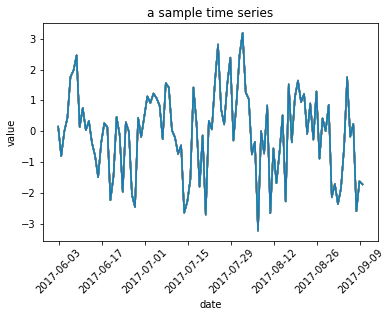

In [29]:
plt.plot(ts)
plt.xlabel("date")
plt.ylabel("value")
plt.title("a sample time series")
plt.xticks(rotation=45)
plt.show()

## Properties of time series

A time series {$s_t$} is called *strictly stationary* if the joint distribution of $(s_{t_1}, \dots, s_{t_k})$ is identical to that of $(s_{t_1 + t}, \dots, s_{t_k+t})$ for any $t$, where $k$ is an arbitrary positive integer. This property is vary hard to verify empirically.

A time series is called *weakly stationary*, if both the mean and the covariance between $s_{t}$ and $s_{t-\ell}$ are time-invariant, where $\ell$ is an arbitrary integer. In other words, a time series is weakly stationary, if $E(s_t)= \mu$ is constant and $Cov(s_{t}, s_{t-\ell}) = \gamma_\ell$ depends only on $\ell$. From the practical point of view, weak stationarity is a highly useful concept.

The covariance $\gamma_\ell$ (also called the lag-$\ell$ autocovariance of $s_t$. Clearly, $\gamma_0 = Var(s_t)$, and $\gamma_{-\ell}= \gamma_{\ell}$.

### Autocorrelation function

Given a weakly stationary time series $s_t$, autocorrelation is used to characterize the linear dependence of $s_t$ on its past values. The autocorrelation is usually treated as a function of the number of lags $\ell$, and

\begin{equation}
\rho_\ell= \dfrac{Cov(s_t, s_{t-\ell})}{\sqrt{Var(s_t)Var(s_{t-\ell})}}= \dfrac{Cov(s_t, s_{t-\ell})}{Var(s_t)}= \dfrac{\gamma_\ell}{\gamma_0},
\end{equation}

where we have utilized that due to the weak stationarity $Var(s_t) = Var(s_{t-\ell})$. A weakly stationary time series is not serially correlated if all the autocorrelation values are zero except $\rho_0$.

The sample autocorrelation function can be calculated as

\begin{equation}
\hat{\rho}_\ell= \dfrac{\sum_{t= \ell + 1}^{T}(s_t - \overline{s})(s_{t-\ell} - \overline{s})}{\sum\limits_{t=1}^{T}(s_t - \overline{s})^2}, \quad 0 \leq \ell < T - 1.
\end{equation}

### The autocorrelation function in practice

Now we use the definition of the autocorrelation function to determine the first two elements of the ACF of the previously generated time series. It can be readily seen that $\hat{\rho}_0 = 1$ always holds. For $\hat{\rho}_1$, the definition reduces to

\begin{equation}
\hat{\rho}_1= \dfrac{\sum_{t= 2}^{T}(s_t - \overline{s})(s_{t-1} - \overline{s})}{\sum\limits_{t=1}^{T}(s_t - \overline{s})^2}.
\end{equation}

In [53]:
def calculate_autocorrelation(ts, ell):
    if ell == 0:
        return 1
    
    mean_ts= np.mean(ts)
    mean_shifted= ts - mean_ts
    numerator= np.dot(mean_shifted.iloc[ell:], mean_shifted.iloc[:-ell])
    denominator= np.dot(mean_shifted, mean_shifted)
    rho_hat= numerator/denominator
    
    return rho_hat

def calculate_autocorrelation_function(ts, max_lag):
    return [calculate_autocorrelation(ts, i) for i in range(max_lag+1)]

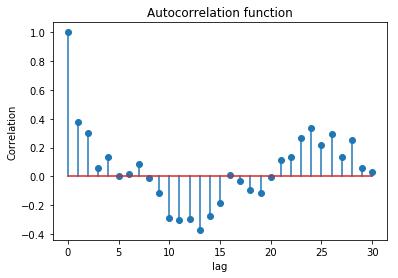

In [56]:
plt.stem(calculate_autocorrelation_function(ts, 30))
plt.xlabel("lag")
plt.ylabel("Correlation")
plt.title("Autocorrelation function")
plt.show()

Luckily, Python has some highly optimized function for the calculation of autocorrelation functions:

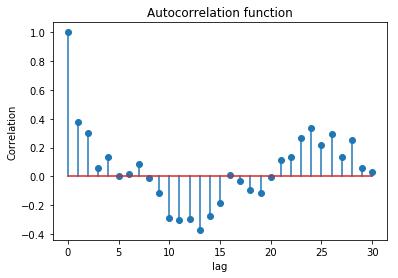

In [58]:
plt.stem(acf(ts, nlags=30))
plt.xlabel("lag")
plt.ylabel("Correlation")
plt.title("Autocorrelation function")
plt.show()

Later on, the autocorrelation function will be used to determine various properties of the time series.

### Uncertainty of the autocorrelation function

The 0 values in the autocorrelation function are especially important, since they reflect that the next value of the time series seems to be not affected by some previous values of it. However, as we work with finite samples in practice, the values in the autocorrelation function have some uncertainty. For example, if we compute the first 30 elements of the autocorrelation function only on the first half of the time series, it will be pretty different from the previous one, even though the same process was used to generate it:

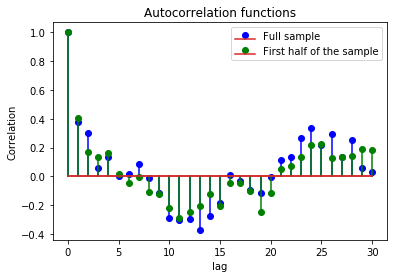

In [67]:
plt.stem(acf(ts, nlags= 30), "b", markerfmt='bo')
plt.stem(acf(ts.iloc[:len(ts)//2], nlags= 30), "g", markerfmt='go')
plt.xlabel("lag")
plt.ylabel("Correlation")
plt.title("Autocorrelation functions")
plt.legend(["Full sample", "First half of the sample"])
plt.show()

As one can see, the autocorrelations deviate, and the deviation increases with the lag number, as for higher number of lags, lower number of samples can be used to determine the correlation. As we usually work with finite samples, the question arises: how can we infer on the values of the autocorrelation function, if they vary with the length of the time series?

Let $s_t$ be a weakly stationary time series generated by the process $s_t = \mu + \sum_{i=0}^{q}\psi_ia_{t-i}$, where $\psi_0=1$, $q$ is a non-negative integer, and {$a_j$} is a Gaussian white noise series. Then, it can be shown that $\hat{\rho}_{l}$ is asymptotically normal with mean zero and variance $\left(1 + 2\sum_{i=1}^{q}\rho_i^2\right)/T$ for all $\ell > q$. This is Bartlett's formula. In practice, this formula can be used to construct a statistical t-test to check the hypothesis $H_0: \rho_{\ell}=0$ against $H_\alpha: \rho_\ell\neq 0$:

$$t\text{-ratio}= \dfrac{\hat{\rho}_{\ell}\sqrt{T}}{\sqrt{\left(1 + 2\sum_{i=1}^{\ell-1}\hat{\rho}_i^2\right)}}$$

Based on the t-ratio statistic, one can reject $H_0$ if $\vert t\text{-ratio}\vert > Z_{\alpha/2}$ holds, where $Z_{\alpha_2}$ is the $100(1 - \alpha/2)$th percentile of the standard normal distribution. Alternatively, one can construct a conficence interval as $[-Z_{\alpha/2}, Z_{\alpha/2}]$, and accept $\hat{\rho}_{\ell}$ as a correlation coefficient significantly different from zero, if the test statistic lies outside the confidence interval. By multiplying $Z_{\alpha/2}$ with 

$$\dfrac{\sqrt{T}}{\sqrt{1 + 2\sum_{i=1}^{\ell-1}\hat{\rho}_i^2}}$$

one converts the interval into a value which is comparable to $\hat{\rho}$ directly. 

For example, let $\alpha= 0.05$. For $\hat{\rho}_1$, the confidenct interval becomes $[-Z_{\alpha/2}\sqrt{1/T}, Z_{\alpha/2}\sqrt{1/T}]$, which is

In [69]:
alpha= 0.05
Z= norm.ppf(1-alpha/2)
lower= -Z*np.sqrt(1/N)
upper= Z*np.sqrt(1/N)

print("rho_1: %f, interval: [%f, %f]" % (calculate_autocorrelation(ts, 1), lower, upper))

rho_1: 0.374519, interval: [-0.195996, 0.195996]


As $\hat{\rho}_1$ is outside the confidence interval, we can conclude that the lag-1 autocorrelation coefficient is significantly different from 0 at the $\alpha= 0.05$ level.

However, up to now no we didn't validate that the time series we are working with, fits the assumptions of this statistical test. In the next subsection we will consider techniques to test the stationarity of time series. However, before that we mention that calculating confidence intervals for autocorrelation functions is so widely used, that Python has some built-in functions to carry out this work:

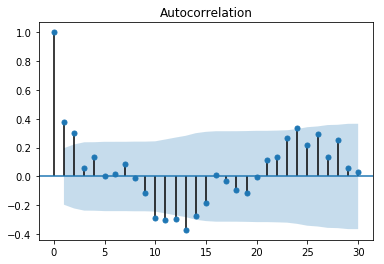

In [71]:
plot_acf(ts, lags= 30)

One can observe that the confidence interval of the lag-1 autocorrelation is exactly the same value as the one we computed before.